In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240529%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240529T093831Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0cb91969a4a54f6a806af87595ae463f18a62a2e9722a4c5eb4cbc72bfadb0896531d82e2d837b16d58402e6d232a861200db7454c11a12c85087f1e73eb3d287204b02ed2651c1778d67ca8351a9b592fca1589b9558356ffda60b6ab9e941c97da0a34d531e78ae2ead9adf7cc4e12e30b2bd8abfc51f146761d98389d9799463a08d020ec3cdbb63f52b02c85a3fec13cc6e4659c27bbcc2fcf4d68b8d6b2008f71cf677bb8601ca45d386ea2ccca3a1a4ed1668476f51fd8273efc920cb429be4ebcec206796d88c1d2e9fa62c093d6e01e51ad65124983d5b7d62d8497d3b700d17db7841de3394fecc0eb27cf5ed00265692f9a91907ed90f10692ffe7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


Loading and Exploring the Dataset
The dataset contains chest X-ray images categorized into Pneumonia and Normal. The dataset is split into training, validation, and testing sets.

In [ ]:
import os
import numpy as np
import pandas as pd
import pathlib
import imageio
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras.applications import VGG16, ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Define directories
base_dir = '../input/chest-xray-pneumonia/chest_xray/'
train_pneumonia_dir = base_dir + 'train/PNEUMONIA/'
train_normal_dir = base_dir + 'train/NORMAL/'
test_pneumonia_dir = base_dir + 'test/PNEUMONIA/'
test_normal_dir = base_dir + 'test/NORMAL/'
val_normal_dir = base_dir + 'val/NORMAL/'
val_pneumonia_dir = base_dir + 'val/PNEUMONIA/'

# Load image paths
train_pn = [train_pneumonia_dir + "{}".format(i) for i in os.listdir(train_pneumonia_dir)]
train_normal = [train_normal_dir + "{}".format(i) for i in os.listdir(train_normal_dir)]
test_pn = [test_pneumonia_dir + "{}".format(i) for i in os.listdir(test_pneumonia_dir)]
test_normal = [test_normal_dir + "{}".format(i) for i in os.listdir(test_normal_dir)]
val_pn = [val_pneumonia_dir + "{}".format(i) for i in os.listdir(val_pneumonia_dir)]
val_normal = [val_normal_dir + "{}".format(i) for i in os.listdir(val_normal_dir)]

# Combine image paths
train_imgs = train_pn + train_normal
test_imgs = test_pn + test_normal
val_imgs = val_pn + val_normal

# Shuffle the datasets
random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

# Print dataset statistics
print("Total Train Images:", len(train_imgs))
print("Total Test Images:", len(test_imgs))
print("Total Validation Images:", len(val_imgs))

Total Train Images: 5216
Total Test Images: 624
Total Validation Images: 16


Preprocessing Images

*   List item
*   List item


We preprocess the images by resizing them to 224x224 pixels, converting them to RGB, and normalizing the pixel values.

In [ ]:
img_size = 224

def preprocess_image(image_list):
    X = []  # images
    y = []  # labels (0 for Normal, 1 for Pneumonia)
    for image in image_list:
        try:
            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
            img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            if 'NORMAL' in image:
                y.append(0)
            else:
                y.append(1)
        except:
            continue
    return np.array(X), np.array(y)

X_train, y_train = preprocess_image(train_imgs)
X_test, y_test = preprocess_image(test_imgs)
X_val, y_val = preprocess_image(val_imgs)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(5216, 224, 224, 3) (5216,)
(624, 224, 224, 3) (624,)
(16, 224, 224, 3) (16,)


**Class Weights**

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

**Model Building**

Conventional CNN
We define a simple CNN architecture with convolutional layers, pooling layers, and fully connected layers.

In [ ]:
  def build_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

**Pre-trained CNN (VGG16)**

We load the VGG16 model, fine-tune the top layers, and add a new fully connected layer for binary classification.

In [ ]:
def build_pretrained_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
vgg_model = build_pretrained_model(vgg_base)
vgg_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

**Model Training**

We use data augmentation to artificially increase the dataset size and prevent overfitting.

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=7, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.2, zoom_range=0.45, horizontal_flip=True)
val_datagen = ImageDataGenerator(zoom_range=0.45)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train Conventional CNN
cnn_history = cnn_model.fit(train_generator, epochs=20, class_weight=class_weights, validation_data=val_generator)

# Train Pre-trained VGG16
vgg_history = vgg_model.fit(train_generator, epochs=20, class_weight=class_weights, validation_data=val_generator)

Epoch 1/20
163/163 [==============================] - 66s 359ms/step - loss: 0.5188 - accuracy: 0.7613 - val_loss: 0.9059 - val_accuracy: 0.6875
Epoch 2/20
163/163 [==============================] - 60s 370ms/step - loss: 0.3465 - accuracy: 0.8439 - val_loss: 0.9174 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 60s 365ms/step - loss: 0.3010 - accuracy: 0.8595 - val_loss: 0.8310 - val_accuracy: 0.5625
Epoch 4/20
163/163 [==============================] - 61s 373ms/step - loss: 0.2813 - accuracy: 0.8767 - val_loss: 0.6542 - val_accuracy: 0.7500
Epoch 5/20
163/163 [==============================] - 61s 373ms/step - loss: 0.2500 - accuracy: 0.8961 - val_loss: 0.5471 - val_accuracy: 0.8750
Epoch 6/20
163/163 [==============================] - 59s 364ms/step - loss: 0.2291 - accuracy: 0.9053 - val_loss: 0.6663 - val_accuracy: 0.7500
Epoch 7/20
163/163 [==============================] - 62s 383ms/step - loss: 0.2026 - accuracy: 0.9132 - val_loss: 1.0207 - val_ac

**Model Evaluation**

We evaluate both models on the test set using accuracy, precision, recall, and F1-score.

In [ ]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    preds = np.round(preds).astype(int)
    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    return acc, precision, recall, f1, cm

cnn_acc, cnn_precision, cnn_recall, cnn_f1, cnn_cm = evaluate_model(cnn_model, X_test, y_test)
vgg_acc, vgg_precision, vgg_recall, vgg_f1, vgg_cm = evaluate_model(vgg_model, X_test, y_test)

print(f"Conventional CNN - Accuracy: {cnn_acc}, Precision: {cnn_precision}, Recall: {cnn_recall}, F1-score: {cnn_f1}")
print(f"VGG16 - Accuracy: {vgg_acc}, Precision: {vgg_precision}, Recall: {vgg_recall}, F1-score: {vgg_f1}")

20/20 [==============================] - 3s 124ms/step
Conventional CNN - Accuracy: 0.8766025641025641, Precision: 0.8845208845208845, Recall: 0.9230769230769231, F1-score: 0.9033877038895859
VGG16 - Accuracy: 0.844551282051282, Precision: 0.9221902017291066, Recall: 0.8205128205128205, F1-score: 0.8683853459972862


**Model Comparison**

We compare the performance of the two models based on the evaluation metrics and visualize the confusion matrices.

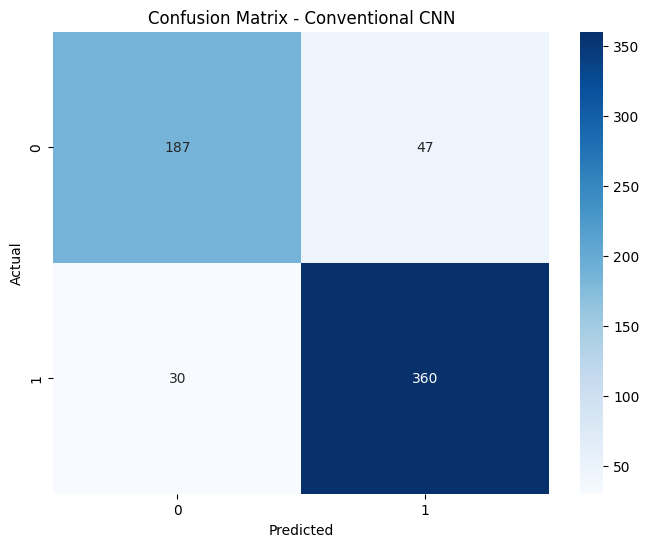

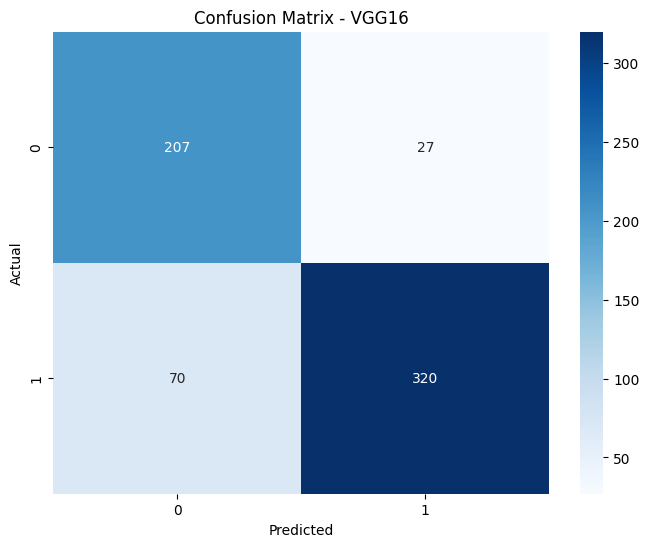

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cnn_cm, "Confusion Matrix - Conventional CNN")
plot_confusion_matrix(vgg_cm, "Confusion Matrix - VGG16")

**Models' Accuracy and Loss**

Plotting the accuracy and loss for both models

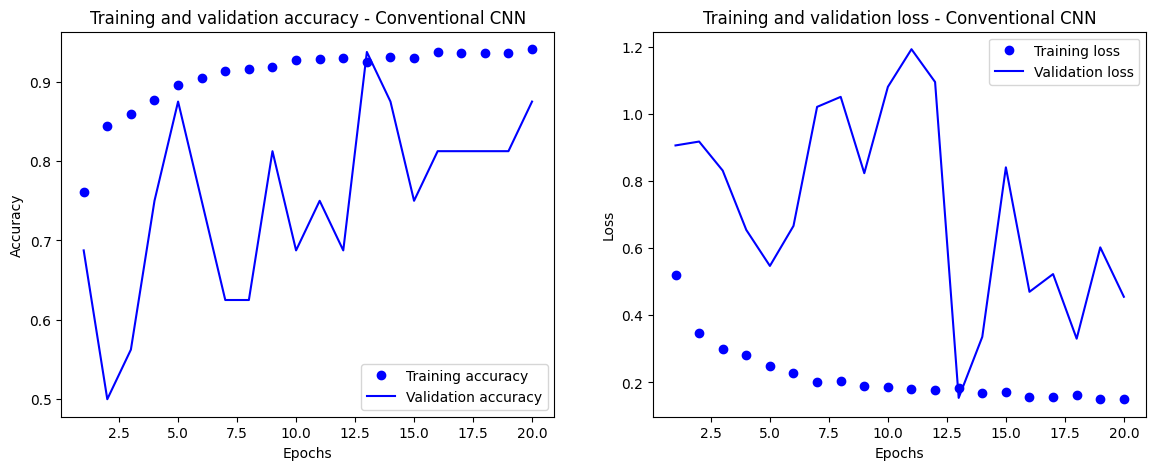

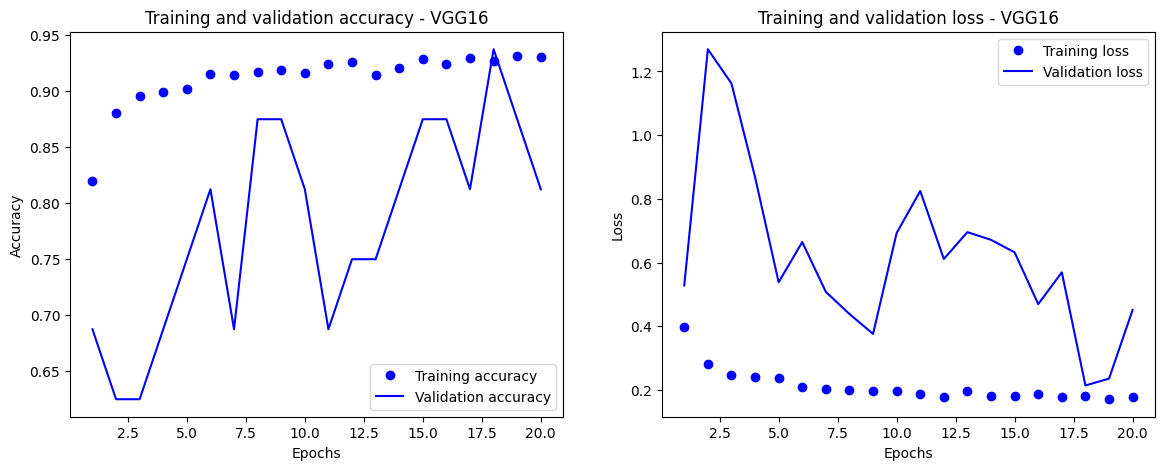

In [ ]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plotting for Conventional CNN
plot_history(cnn_history, "Conventional CNN")

# Plotting for VGG16
plot_history(vgg_history, "VGG16")